In [1]:
import os
import sys
sys.path.append("../data/neural_data/")
sys.path.append("../utils/")
sys.path.append("../fig1_1d2map/")
from pathlib import Path

import numpy as np
import itertools
import matplotlib.pyplot as plt

import basic_analysis as basic
import fig6_analysis as analysis
import analysis_neuro as spk
import fig6_plots

In [2]:
# file paths
data_folder = f"../data/neural_data/multi_map/"
save_folder = f"../figures/fig6_plots/"
if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
    
title_size = 10

save folder exists


In [3]:
session_IDs = os.listdir(data_folder)
session_IDs = session_IDs[:-1]

# sort for plotting
session_order = np.asarray([1, 2, 0, 3])
sorted_sessions = []
for idx in session_order:
    sorted_sessions.append(session_IDs[idx])

# number of maps per session
session_maps = np.asarray([3, 3, 4, 4])

In [5]:
''' load the data - single neuron and similarity '''
ex_idx = 0
session_ID = sorted_sessions[ex_idx]
c_id = 529
n_maps = session_maps[ex_idx]
d = analysis.load_neural_data(data_folder, session_ID)
print(f'loaded data for {session_ID}')

loaded data for Seattle_1010_1


In [6]:
''' divide by map and filter out unstable trials '''
d = analysis.format_neural_data(d, n_maps=n_maps,
                                filter_stability=True, unstable_thresh=0.25)

In [7]:
''' compute firing rates for each map '''
A = d['A']
B = d['B']

dt = 0.02 # time bin
pos_bin = 2 # cm
n_cells = B.shape[-1]
n_pos_bins = 400 // pos_bin

FRs = np.zeros([n_maps, n_pos_bins, n_cells])
FRs_sem = np.zeros([n_maps, n_pos_bins, n_cells])
for i in range(n_maps):
    m_idx = d['idx'][i, :]
    FRs[i], binned_pos, FRs_sem[i] = spk.tuning_curve(A[m_idx, 0],
                                             B[m_idx, :],
                                             dt, b=2, SEM=True)

In [8]:
''' save remap index for plotting '''
W = d['kmeans']['W']
trials = np.arange(0, W.shape[0]-1)

# define remaps
remap_idx = np.asarray([])
for i in range(n_maps):
    remaps = np.where(np.abs(np.diff(W[:, i])))[0]
    remap_idx = np.append(remap_idx, remaps)
remap_idx = np.unique(remap_idx)
remap_idx = remap_idx.astype(int)
d['remap_idx'] = remap_idx

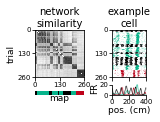

In [9]:
''' Figure 6A: 3 map examples for a single cell and the whole network '''
f, gs = fig6_plots.plot_b(d=d, cell_ID=c_id,
                          all_FR=FRs,
                          all_FR_sem=FRs_sem,
                          binned_pos=binned_pos)

f.savefig(f'{save_folder}{session_ID}_examples.png',
          dpi=600, bbox_inches='tight')
plt.show()

In [4]:
''' load the data - manifolds '''
ex_idx = -1
session_ID = sorted_sessions[ex_idx]
n_maps = session_maps[ex_idx]
d = analysis.load_neural_data(data_folder, session_ID)
print(f'loaded data for {session_ID}')

loaded data for Toronto_1117_1


In [5]:
''' divide by map and filter out unstable trials '''
d = analysis.format_neural_data(d, n_maps=n_maps,
                                filter_stability=True, unstable_thresh=0.25)

In [6]:
# define the map pairs
m_ids = np.arange(n_maps)
m_pairs = list(itertools.combinations(m_ids,2))
for i, p in enumerate(m_pairs):
    m_pairs[i] = np.asarray(p)

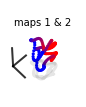

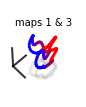

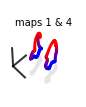

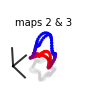

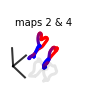

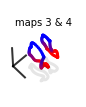

In [7]:
''' Figure 6B: example aligned manifolds for all pairs '''
# get the centers for each position bin
pos = d['A'][:, 0]
bin_size = 5
edges = np.arange(0, np.max(pos) + bin_size, bin_size)
binned_pos = (edges[:-1] + edges[1:])/2

# data params
Y = d['Y'].copy()
map_idx = d['idx']
W = d['kmeans']['W'].copy()
W_bool = W.astype(bool)

# plots
for i, (m0_id, m1_id) in enumerate(m_pairs):
    map_idx = W_bool[:, m0_id] | W_bool[:, m1_id]
    
    if (i == 0) or (i==3): # rotate maps as needed to show separation
        f, ax = fig6_plots.plot_c(Y[map_idx], binned_pos, reflect_y=True)
    else:
        f, ax = fig6_plots.plot_c(Y[map_idx], binned_pos)
    ax.set_title(f'maps {m0_id+1} & {m1_id+1}',
                 fontsize=title_size, pad=-2)
    
    plt.show()
    f.savefig(f'{save_folder}{session_ID}_manifolds_{m0_id+1}{m1_id+1}.png', 
              dpi=600, bbox_inches='tight')

overall mean misalignment = 0.69
overall sem misalignment = 0.056
Seattle_1006_1 mean misalignment = 1.0
Seattle_1010_1 mean misalignment = 0.54
Toronto_1111_1 mean misalignment = 0.78
Toronto_1117_1 mean misalignment = 0.51


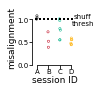

In [16]:
''' Figure 6C: summary of ring alignment '''
f, ax = fig6_plots.plot_d(data_folder, session_IDs, session_maps)
f.savefig(f'{save_folder}alignment_sort.png', dpi=600, bbox_inches='tight')
plt.show()

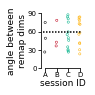

In [17]:
''' Figure 6D: angle between remapping dimensions '''
f, ax = fig6_plots.plot_e(data_folder, session_IDs, session_maps)
f.savefig(f'{save_folder}remap_angles.png', dpi=600, bbox_inches='tight')
plt.show()